# Connect Eye-AI and Load Libraries

In [1]:
repo_dir = "Repos"   # Set this to be where your github repos are located.
%load_ext autoreload
%autoreload 2

# # Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-ml"))
sys.path.insert(0, str(Path.home() / repo_dir / "eye-ai-exec"))

In [2]:
# Prerequisites
import json
import os
import shutil
from PIL import Image

# EyeAI, Deriva, VGG19
from deriva_ml import DatasetSpec, DatasetBag, Workflow, ExecutionConfiguration, VersionPart
from deriva_ml import MLVocab as vc
from eye_ai.eye_ai import EyeAI
from models.vgg19 import vgg19_diagnosis_train

# ML Analytics
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Other Utilities
from pathlib import Path, PurePath
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

2025-06-30 12:12:52.362486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-30 12:12:52.362546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-30 12:12:52.494553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-30 12:12:52.777090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-30 12:12:54.499385: W tensorflow/compiler/tf2

In [3]:
# Login
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
host = 'www.eye-ai.org'
#host = 'dev.eye-ai.org' #for dev testing
catalog_id = "eye-ai"

gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-06-30 12:12:56,326 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-30 12:12:56,327 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-30 12:12:56,329 - INFO - Setting up RefreshTokenAuthorizer with auth_client=[instance:140373539451856]
2025-06-30 12:12:56,330 - INFO - Setting up a RenewingAuthorizer. It will use an auth type of Bearer and can handle 401s.
2025-06-30 12:12:56,330 - INFO - RenewingAuthorizer will start by using access_token with hash "3abdea4d66ce49b3b6ae190010f35990d2eb7e3299bcbde28fb6bbd7d20c3e24"
2025-06-30 12:12:56,331 - INFO - Executing token refresh without client credentials
2025-06-30 12:12:56,331 - INFO - Fetching new token from Globus Auth
2025-06-30 12:12:56,855 - INFO - request done (success)
2025-06-30 12:12:56,856 - INFO - RenewingAuthorizer.

You are already logged in.


# Configuration

In [4]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-06-30 12:13:02,925 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-30 12:13:02,926 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [5]:
# Increment dataset if changed

# EA.increment_dataset_version(dataset_rid='4-YWKJ', component= VersionPart.patch, description='Update after annotations added')

In [6]:
source_dataset = "4-YWKJ" # USC test set
crop = False

if crop:
    asset_RID = ["4-MWQ6"]  # VGG19 cropped
else:
    asset_RID = ["4-MWQ8"]  # VGG19 uncropped

preds_workflow = EA.add_workflow( 
    Workflow(
        name="VGG Predictions by KB",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/VGG_Multi_Predict.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=[ DatasetSpec(rid=source_dataset, version=EA.dataset_version(source_dataset), materialize=True) ],
    assets=asset_RID,
    workflow=preds_workflow,
    description=f"Instance of creating VGG19 predictions: VGG19 on 4-YWKJ USC Test with Crop = {crop}",
    )

execution = EA.create_execution(config)

2025-06-30 12:13:07,194 - INFO - Materialize bag 4-YWKJ... 
2025-06-30 12:13:07,304 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-30 12:13:07,305 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-30 12:13:08,978 - INFO - Using cached bag for  4-YWKJ Version:0.2.0
2025-06-30 12:13:08,979 - INFO - Loading /data/4-YWKJ_44b67c208c639554dd582f1575a7466fd853affad87411a7f99d28c7559acbbb/Dataset_4-YWKJ
2025-06-30 12:13:09,635 - INFO - Creating new database for dataset: 4-YWKJ in /data/kb_766/EyeAI_working/4-YWKJ@33F-J5QX-5CCA.db
2025-06-30 12:13:09,689 - INFO - Downloading assets ...
2025-06-30 12:13:19,204 - INFO - File [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXK0/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Uncropped_2-277G_Feb_14_2025.h5] transfer successful. 22

In [7]:
print(execution)

caching_dir: /data
_working_dir: /data/kb_766/EyeAI_working
execution_rid: 4-YXCC
workflow_rid: 4-YSP4
asset_paths: {'Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXCC/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Uncropped_2-277G_Feb_14_2025.h5')]}
configuration: datasets=[DatasetSpec(rid='4-YWKJ', materialize=True, version=DatasetVersion(major=0, minor=2, patch=0))] assets=['4-MWQ8'] workflow='4-YSP4' parameters={} description='Instance of creating VGG19 predictions: VGG19 Uncropped on 4-YWKJ USC Test' argv=['/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-53b81482-309f-428d-9422-74fb6f1dc323.json']


In [8]:
output_dir = execution._working_dir / execution.execution_rid

# Organize Data into Directories for ML

In [8]:
ds_bag_test = execution.datasets[0]

In [13]:
dbImage = ds_bag_test.get_table_as_dataframe('Image')

In [21]:
dates = dbImage['Date_of_Encounter'][dbImage['Date_of_Encounter'] != '']
min(dates), max(dates)

('2021-05-24 00:00:00', '2024-04-10 00:00:00')

In [10]:
# FOR USC MULTIMODAL DATA
# Group files as glaucoma/not for VGG evaluation

imageDF = ds_bag_test.get_table_as_dataframe('Image')
annotation_bounding_box =  pd.merge( ds_bag_test.get_table_as_dataframe('Annotation')[['Image', 'Fundus_Bounding_Box']], 
                                                ds_bag_test.get_table_as_dataframe('Fundus_Bounding_Box'), 
                                                left_on='Fundus_Bounding_Box', 
                                                right_on='RID')

output_path =  output_dir / "Test"
output_path_suspected = output_path / "No_Glaucoma"
output_path_glaucoma = output_path / "Suspected_Glaucoma"

output_path.mkdir(parents=True, exist_ok=True)
output_path_suspected.mkdir(parents=True, exist_ok=True)
output_path_glaucoma.mkdir(parents=True, exist_ok=True)

for index, row in imageDF.iterrows():     
    src_path = row["Filename"]
    image_rid = row["RID"]
    dest_name = image_rid + ".jpg"
    if crop: dest_name = "Crop_" + dest_name
    label = image_rid.split( sep = "-" )[0]
    
    if label == "4":
        dest_path = os.path.join(output_path_suspected, dest_name)
    elif label == "2":
        dest_path = os.path.join(output_path_glaucoma, dest_name)
    else: 
        continue    
    
    if crop:
        image = Image.open(src_path)
        svg_path = annotation_bounding_box.loc[annotation_bounding_box['Image'] == image_rid, 'Filename'].values[0]
        svg_path = Path(svg_path)
        if not svg_path.exists():
          continue
        bbox = EA.get_bounding_box(svg_path)
        cropped_image = image.crop(bbox)
        cropped_image.save(dest_path)
    else:
        shutil.copy2(src_path, dest_path)

output_path

PosixPath('/data/kb_766/EyeAI_working/4-YXCC/Test')

In [ ]:
!ls /data/kb_766/EyeAI_working/4-YX7M/Test

In [ ]:
!ls /data/kb_766/EyeAI_working/4-YX7M/Test/No_Glaucoma

In [ ]:
!ls /data/kb_766/EyeAI_working/4-YX7M/Test/No_Glaucoma -1 | wc -l

In [ ]:
!ls /data/kb_766/EyeAI_working/4-YX7M/Test/Suspected_Glaucoma

In [ ]:
!ls /data/kb_766/EyeAI_working/4-YX7M/Test/Suspected_Glaucoma -1 | wc -l

# Run ML

In [11]:
asset_output_dir = execution._working_dir / execution.execution_rid / "asset"
asset_output_dir.mkdir( parents=True, exist_ok=True )

In [12]:
current_date = datetime.now().strftime("%b_%d_%Y") 

In [13]:
model_path = str(execution.asset_paths['Execution_Asset'][0])

In [14]:

with execution.execute() as exec:
        predictions_results, metrics_summary = vgg19_diagnosis_train.evaluate_only(
            model_path = model_path, 
            model_name = f"VGG19_Cropped_Model_{ds_bag_test.dataset_rid}_{current_date}", 
            test_path = output_path, 
            output_dir = asset_output_dir,
            classes = {'No_Glaucoma': 0, 'Suspected_Glaucoma': 1}
        )
        print("Execution Results:")
        print(predictions_results, metrics_summary)

2025-06-23 12:25:13,113 - INFO - Start execution  ...
2025-06-23 12:25:13,207 - INFO - Start execution  ...
2025-06-23 12:25:13.346469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-23 12:25:13.374866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-23 12:25:13.378516: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node

Found 300 images belonging to 2 classes.


2025-06-23 12:25:15.259713: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-23 12:25:29,545 - INFO - Predictions saved to VGG19_Cropped_Model_4-YWKJ_Jun_23_2025_predictions_results.csv
2025-06-23 12:25:29,545 - INFO - Metrics saved to VGG19_Cropped_Model_4-YWKJ_Jun_23_2025_metrics_summary.csv
2025-06-23 12:25:29,546 - INFO - Successfully run Ml.
2025-06-23 12:25:29,620 - INFO - Algorithm execution ended.


Execution Results:
/data/kb_766/EyeAI_working/4-YXCC/asset/VGG19_Cropped_Model_4-YWKJ_Jun_23_2025_predictions_results.csv /data/kb_766/EyeAI_working/4-YXCC/asset/VGG19_Cropped_Model_4-YWKJ_Jun_23_2025_metrics_summary.csv


# Evaluate ML

In [15]:
pd.read_csv( metrics_summary )

,Metric,Value
0,F1 Score,0.647520
1,Precision,0.532189
2,Recall,0.826667
3,Accuracy,0.550000
4,ROC-AUC,0.633778


In [16]:
preds = pd.read_csv( predictions_results )

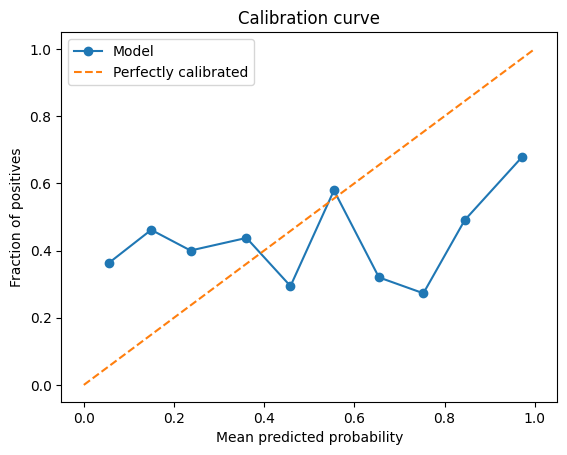

In [17]:
# Calibration curve
prob_true, prob_pred = calibration_curve( preds["True Label"], preds["Probability Score"], n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()

# Upload Results

In [18]:
#This loop creates copies.
for filename in os.listdir(asset_output_dir):
    file_path = os.path.join(asset_output_dir, filename)
    if os.path.isfile(file_path):
        asset_type = ""
        if filename.endswith(('csv', 'jpg', 'txt')):
            asset_type = "Model_Prediction"
        elif filename.endswith('pth'):
            asset_type = "Diagnosis_Model"
        if asset_type != "":
            path = execution.asset_file_path(
                asset_name="Execution_Asset",
                file_name=file_path,
                asset_types=asset_type
            )


In [19]:
# upload assets to catalog
exec.upload_execution_outputs(clean_folder=True)

2025-06-23 12:27:16,381 - INFO - Uploading execution files...
2025-06-23 12:27:16,460 - INFO - Initializing uploader: GenericUploader v1.7.7 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2025-06-23 12:27:16,461 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-23 12:27:16,462 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-23 12:27:16,500 - INFO - Scanning files in directory [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXCC/asset]...
2025-06-23 12:27:16,503 - INFO - Including file: [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXCC/asset/deriva-ml/Execution_Metadata/configuration.json].
2025-06-23 12:27:16,503 - INFO - Including file: [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXCC/asset/deriva-ml/Execution_Metadata/environment_sn

{'deriva-ml/Execution_Metadata': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXCC/asset/deriva-ml/Execution_Metadata/configuration.json'),
  AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXCC/asset/deriva-ml/Execution_Metadata/environment_snapshot_20250623_122433.txt')],
 'deriva-ml/Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXCC/asset/deriva-ml/Execution_Asset/VGG19_Cropped_Model_4-YWKJ_Jun_23_2025_predictions_results.csv'),
  AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YXCC/asset/deriva-ml/Execution_Asset/VGG19_Cropped_Model_4-YWKJ_Jun_23_2025_metrics_summary.csv')]}